In [16]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from Signal_Analyzer import  *
from UNetGenerator import *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [17]:
class CIN(nn.Module):
    def __init__(self, num_features, num_latent_variables):
        super(CIN, self).__init__()
        self.num_features = num_features
        self.inst_norm = nn.InstanceNorm1d(num_features, affine=False)
        self.conv_alpha = nn.Conv1d(in_channels=num_latent_variables, out_channels=num_features, kernel_size=1)
        self.conv_beta = nn.Conv1d(in_channels=num_latent_variables, out_channels=num_features, kernel_size=1)

    def forward(self, x, z):
        out = self.inst_norm(x)
        
        alpha = self.conv_alpha(z)
        beta = self.conv_beta(z)
        
        alpha = alpha.expand_as(out)
        beta = beta.expand_as(out)

        return alpha * out + beta

In [18]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_latent_variables, no_norm=False):
        super(ResBlock, self).__init__()
        self.no_norm = no_norm

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.process1 = CIN(in_channels, num_latent_variables) if not no_norm else nn.Identity()
        self.process2 = CIN(out_channels, num_latent_variables) if not no_norm else nn.Identity()

    def forward(self, x, z):
        processed1 = self.process1(x, z) if not self.no_norm else x
        conv1_out = self.conv1(processed1)
        conv1_activated = self.leaky_relu(processed1)

        processed2 = self.process2(conv1_activated, z) if not self.no_norm else conv1_activated
        conv2_out = self.conv2(processed2)
        conv2_activated = self.leaky_relu(conv2_out)

        conv3_out = self.conv3(conv2_activated)

        return conv3_out + conv1_out

In [19]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, num_latent_variables):
        super(Down, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.avg_pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.res_block = ResBlock(in_channels=out_channels, out_channels=out_channels, num_latent_variables=num_latent_variables, no_norm=False)

    def forward(self, x, condition):
        x = self.conv(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = self.res_block(x, condition)
        return x

In [23]:
class UNetDiscriminator(nn.Module):
    def __init__(self, input_channels, base_filters=64, num_latent_variables=0):
        super(UNetDiscriminator, self).__init__()

        # Initial convolution block
        self.init_conv = nn.Conv1d(input_channels, base_filters, kernel_size=3, stride=1, padding=1)
        self.init_leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        # ResBlock without normalization
        # Ensure to pass num_latent_variables to the ResBlock
        self.res_block_no_norm = ResBlock(base_filters, base_filters, num_latent_variables, no_norm=True)

        # Down-sampling layers
        self.down1 = Down(base_filters, base_filters * 2, num_latent_variables)
        self.down2 = Down(base_filters * 2, base_filters * 4, num_latent_variables)
        self.down3 = Down(base_filters * 4, base_filters * 8, num_latent_variables)

        # Flatten and Dense layers
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(base_filters * 8 * (1000 // 2 // 2 // 2), 128)  
        self.dense_leaky_relu = nn.LeakyReLU(0.2)
        self.layer_norm = nn.LayerNorm(128)
        self.final_dense = nn.Linear(128, 1)

    def forward(self, x, z):
        # Pass through initial conv layer and Leaky ReLU
        x = self.init_conv(x)
        x = self.init_leaky_relu(x)

        # Pass through ResBlock without normalization
        x = self.res_block_no_norm(x, z)

        # Down-sampling steps
        x = self.down1(x, z)
        x = self.down2(x, z)
        x = self.down3(x, z)

        # Flatten and pass through dense layers
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense_leaky_relu(x)
        x = self.layer_norm(x)
        x = self.final_dense(x)

        return x

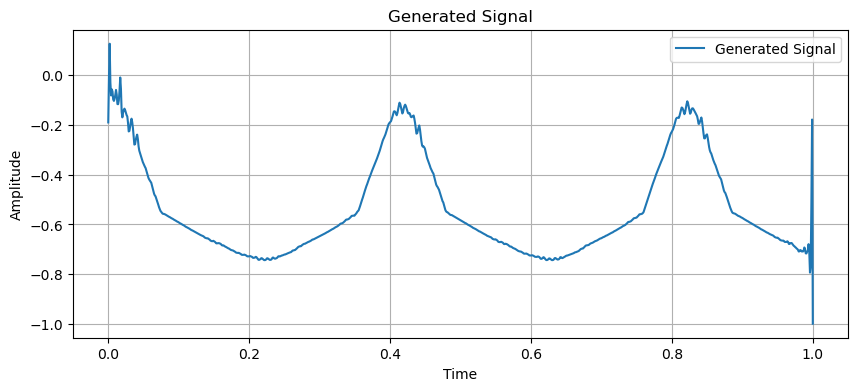

In [24]:
t = np.linspace(0, 1, 1000)

num_latent_variables = 10

z = torch.randn(1, num_latent_variables, 1)


amplitude_range=(0.5, 1.5)
phase_range=(0, np.pi)
frequency_range=(1, 5)

amplitude = np.random.uniform(*amplitude_range)
phase = np.random.uniform(*phase_range)
frequency = np.random.uniform(*frequency_range) 

input_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)

# Initialize the generator
generator = UNetGenerator(in_channels=1, out_channels=1, num_latent_variables=num_latent_variables)

# Generate the signal with the corrected generator
with torch.no_grad():
    generated_signal = generator(input_signal_tensor, z).squeeze().numpy()

plt.figure(figsize=(10, 4))
plt.plot(t, generated_signal, label='Generated Signal')
plt.title('Generated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
discriminator = UNetDiscriminator(input_channels=1, base_filters=64, num_latent_variables=num_latent_variables)

with torch.no_grad():
    generated_signal_tensor = torch.tensor(generated_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    discriminator_output_generated = discriminator(generated_signal_tensor, z)

    discriminator_output_input = discriminator(input_signal_tensor, z)

print(discriminator_output_generated.item())
print(discriminator_output_input.item())

-0.38095077872276306
-0.4650208055973053
